In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

open Blueband,Redband, NIRband, SWIRband as array and fillvalue replace by np.nan

In [2]:
#import all bands as array
path="F:\Landsat_level2data\LC081450452019101401T1-SC20200515155014\LC08_L1TP_145045_20191014_20191018_01_T1_sr_band"
blue=gdal.Open(path+"2.tif")
blueband=blue.GetRasterBand(1).ReadAsArray()
blueband=blueband.astype("float")
blueband[blueband<0]=np.nan

Red=gdal.Open(path+"4.tif")
Redband=Red.GetRasterBand(1).ReadAsArray()
Redband=Redband.astype("float")
Redband[Redband<0]=np.nan

NIR=gdal.Open(path+"5.tif")
NIRband=NIR.GetRasterBand(1).ReadAsArray()
NIRband=NIRband.astype("float")
NIRband[NIRband<0]=np.nan

SWIR=gdal.Open(path+"6.tif")
SWIRband=SWIR.GetRasterBand(1).ReadAsArray()
SWIRband=SWIRband.astype("float")
SWIRband[SWIRband<0]=np.nan

In [3]:
### clip small area extent
#a,b=1000,6000
#blueband=blueband[a:b,a:b]
#Redband=Redband[a:b,a:b]
#NIRband=NIRband[a:b,a:b]
#SWIRband=SWIRband[a:b,a:b]

function to calculate emissivity. 
if vegetated area, emissivity is calculated based on NDWI. soil threshold -0.02 and vegetation threshold 0.4 . 
if non vegetated area, emissivity is calculated based on EVI. soil threshold 0.12 and vegetation threshold 0.41

In [4]:
satellite="landsat8"
### soil emissivity es
if satellite=="landsat8":
    es=-0.00000475*Redband+0.9788
if satellite=="landsat7":
    es=-0.00000408*Redband+0.9796

def emissivity_veg():
    NDWI=(NIRband-SWIRband)/(NIRband+SWIRband)
    fv=((NDWI+0.02)/(NDWI+0.4))**2
    fv[fv>=1]=1
    ev=0.985
    c=0.02*fv*(1-fv)
    c[c==0]=0.005
    e=np.zeros((NDWI.shape[0],NDWI.shape[1]))
    for i in range(e.shape[0]):
        for j in range (e.shape[1]):
            if NDWI[i,j]==np.nan:
                continue
            
            if NDWI[i,j]<-0.02:
                e[i,j]=es[i,j]
            
            if NDWI[i,j]>=-0.02 and NDWI[i,j]<=0.4:
                e[i,j]=fv[i,j]*ev+(1-fv[i,j])*es[i,j]+c[i,j]
            
            if NDWI[i,j]>0.4:
                e[i,j]=ev
    return e

def emissivity_non_veg():
    EVI=(2.5*(NIRband-Redband))/(NIRband+6*Redband-7.5*blueband+10000)
    fv=((EVI-0.12)/(EVI+0.41))**2
    fv[fv>=1]=1
    ev=0.985
    c=0.02*fv*(1-fv)
    c[c==0]=0.005
    e=np.zeros((EVI.shape[0],EVI.shape[1]))
    for i in range(e.shape[0]):
        for j in range (e.shape[1]):
            if EVI[i,j]==np.nan:
                continue
            
            if EVI[i,j]<0.12:
                e[i,j]=es[i,j]
            
            if EVI[i,j]>=0.12 and EVI[i,j]<=0.41:
                e[i,j]=fv[i,j]*ev+(1-fv[i,j])*es[i,j]+c[i,j]
            
            if EVI[i,j]>0.4:
                e[i,j]=ev
    return e

NDVI mean calculation to identify the area (vegetated(NDVI MEAN>0.25) or non vegetated(NDVI MEAN<=0.25))

In [5]:
NDVI=(NIRband-Redband)/(NIRband+Redband)
NDVImean=np.nanmean(NDVI)
print(NDVImean)

def emissivity():
    if NDVImean>0.25:
        emissivity=emissivity_veg()
    if NDVImean<=0.25:
        emissivity=emissivity_non_veg()
    return emissivity

0.679484398429352


In [6]:
emissivity=emissivity()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


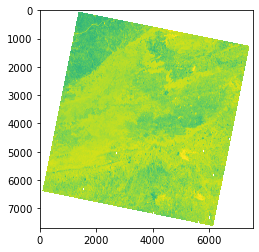

In [7]:
emissivity[emissivity==0.0]=np.nan
plt.imshow(emissivity)

In [8]:
np.nanmin(emissivity),np.nanmax(emissivity)

(0.9529030000000001, 0.985)